# <font color='blue'> Predicting Travel Time Along M4 Highway at Sydney (Segment '40010')</font>
## <font color='green'>Written by Dr. B. K. Kannan </font>
### <font color='green'> 13 September 2018 </font>

### 1) Background
* Given data set contains date, time and the travel time for the segment '40010' which is around 3 km long.
* Some observations on data set:
 * Data starts: 01 March 2010  14:48
 * Data end: 08 Novomber 2010  08:01
 * Number of missing data: 24507 (marked with 'x')
 * Number of data to be Predicted: 290


### 3) Problem Definition
**One important thing in data science realted task is to define the problem at hand clearly with no ambiguity**. In this task, we need to predict the travel time for those data marked with 'x' together with thier respecive confidence intervals based on the historical data. 

Before we delve into the modeling and analysis let's look at the factors that may impact the travel time. I have included some of the important factors below:
* **Day of the Week:** Week days, Weekend, school holidays, public holidays
* **Time of the Day:** Peak hours, Normal hours. Peak hours can be morning or evening peak hours with different characteristics.
* **Type of Transports:** walk, car, trucks etc. 
* **Weather Conditions:** rainy days, storms, high tempratures etc.
* **Extreme Events:** Accidents (can vary based on the severity), road constructions, security threats etc. 


 

### 3) Data Cleaning, Pre-processing and Transformation
This is one of the important step in any modeling, intepretation or prediction related application.
* As mentioned above, I have removed those data with 'NaN' values. There is no need to do any kind of filling based on the context of this problem.
* Class labels for distinguishing the 'Days of the Week' are added to the data frame. 


In [63]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
from datetime import date, timedelta
import matplotlib.pyplot as plt

import matplotlib.dates as dates
import warnings
warnings.filterwarnings('ignore')

#assign dummy coding
def assign_dummy_coding(hd):
    ff = pd.get_dummies(hd['Weekday'].values)
    ff = ff.rename(columns={0: 'wdays',1: 'wend',2: 'phol',3: 'shol'})
    hdf =hd
    hdf['wdays'] = ff['wdays'].values
    hdf['wend'] = ff['wend'].values
    hdf['phol'] = ff['phol'].values
    hdf['shol'] = ff['shol'].values
    
    ff =pd.get_dummies(hd['Peakhour'].values)
    ff = ff.rename(columns={0: 'norm',1: 'peak1',2: 'peak2'})
    hdf['norm'] = ff['norm'].values
    hdf['peak1'] = ff['peak1'].values
    hdf['peak2'] = ff['peak2'].values
    
    return hdf

# get the school holidays
def get_school_holidays():
    
    dhols = []
    holidays = pd.read_csv('schoolholidays.csv', index_col=None)
    dts      = [datetime.strptime(twd, '%m/%d/%Y') for twd in holidays['start'].values]
    dte      = [datetime.strptime(twd, '%m/%d/%Y') for twd in holidays['end'].values]
    
    for id in range(0, len(dts)):
        delta = dte[id] - dts[id]
        for jd in range(delta.days+1):
            dhols.append(dts[id] + timedelta(jd))
    return dhols

# get the public holidays
def get_public_holidays():

    holidays = pd.read_csv('publicholidyas.csv', index_col=None)
    dts      = [datetime.strptime(twd, '%m/%d/%Y') for twd in holidays['date'].values]
    return dts

# Assign class labels for school and public holidays
def assign_public_schoolholidayclass(data):
      ph = get_public_holidays()
      sh = get_school_holidays()
      dt      = [datetime.strptime(twd, '%m/%d/%Y') for twd in data['Date'].values]
      i=0
      for idt in dt:
          
          if idt in ph:
              data['Weekday'].values[i] = 2
              
          if idt in sh:
              if data['Weekday'].values[i] !=1:
                  data['Weekday'].values[i] = 3
              
          i= i+ 1
      return data
  
    
# encode Week days and peak hours
def encode_WeekDays_PeakHours(data):
    ###assign weekday and weekend indices
    wdstr  = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
    wd_end = [1,0,0,0,0,0,1]
    wd     = [datetime.strptime(twd, '%m/%d/%Y').strftime('%a') for twd in data['Date'].values]
    wdC    = [wd_end[wdstr.index(iwd)] for iwd in wd]
    data['Weekday'] = wdC

    #timestamps from the beginning of a day
    pt              = [datetime.strptime(x,'%H:%M:%S') for x in data['Time'].values]
    total_seconds   = [ipt.second+ipt.minute*60+ipt.hour*3600 for ipt in pt]
    data['totsecs'] = total_seconds
    

    #Assign peak/normal hours labels
    Pkhour1_S = 0 + 30*60+7*3600
    Pkhour1_E = 0 + 30*60+9*3600

    Pkhour2_S = 0 + 30*60+15*3600
    Pkhour2_E = 0 + 0*60+19*3600

    #night hour
    Nghthour1_S  = 0 + 0*60+19*3600
    Nghthour1_E = 0 + 60*60+23*3600

    Nghthour2_S  = 0 + 0*60+0*3600
    Nghtkhour2_E = 0 + 30*60+7*3600

    # normal hour
    Norhour_S = 0 + 30*60+9*3600
    Norhour_E = 0 + 30*60+15*3600


    PHC = []

    for it in total_seconds:
        if (it>=0) & (it<Pkhour1_S):
            PHC.append(0)
        elif (it>=Pkhour1_S) & (it<=Pkhour1_E):
            PHC.append(1)
        elif (it>Pkhour1_E) & (it<Pkhour2_S):
            PHC.append(0)
        elif (it>=Pkhour2_S) & (it<=Pkhour2_E):
            PHC.append(2)
        else:
            PHC.append(0)

    data['Peakhour'] = PHC
    
    
    # convert travel_time to floats
    # assign -1 to unknown travel time 
    izX = np.where(data['travel_time'].values=='x')
    izX = izX[0]
    data['travel_time'].values[izX] = -1
    data['travel_time'] = np.asarray([float(x) for x in data['travel_time'].values])

    #datetime obj for future use
    dtstr= data['Date'] + ' ' + data['Time']
    data['dtstr'] = dtstr
    dtobj = [datetime.strptime(twd, '%m/%d/%Y %H:%M:%S').timestamp() for twd in dtstr]
    data['dtobj'] = dtobj

    
    # Assign public and school holiday labels 
    data = assign_public_schoolholidayclass(data)
    
    return data
#remove missing data (nan values)
def rem_missing(data):
    # missing values: remove the missing values fromt eh historical data
    missing_nan     = np.isnan(data['travel_time'].values)
    missing_nan_ind = np.where(missing_nan==False)
    data = data.iloc[missing_nan_ind[0]]
    
    return data

##########################################################
#read the data
filename = '40010.csv'
data     = pd.read_csv(filename, index_col=None)
##########################################################
#encode Weekdays, Peakhours and add few other extra columns: timestamps
data = encode_WeekDays_PeakHours(data)
#include dummy coding
data = assign_dummy_coding(data)

#seperate the hist data with travel time and the data to be predicted (with -1)
#data to be used for traiing and testing phase
iznX = np.where(data['travel_time'].values!=-1)
iznX = iznX[0]
histdata = data.iloc[iznX]

#data to be predicted
iznX = np.where(data['travel_time'].values==-1)
iznX = iznX[0]
preddata = data.iloc[iznX]

# missing values: remove the missing values from the historical data
histdata = rem_missing(histdata)


### 4) Exploratory Data Analysis (EDA)
Let's look at the time series of historical data (with travel times) based on "Days of the Week" (see Section 3 above). Evolution of time series for different "Days of the Week": normal week day, weekend, school holidays and public holidays are plotted below in figures(1-4). 


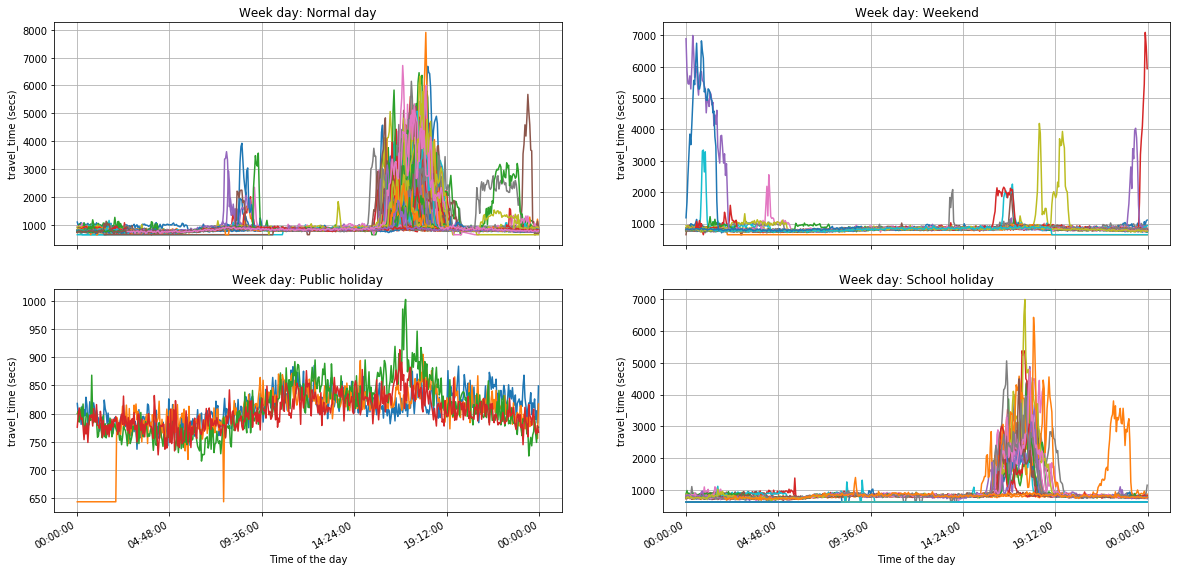

In [65]:
def plot_days(inData, iwd, ax):
    ll=['Normal day','Weekend', 'Public holiday', 'School holiday']
    
    
    tmp = inData[inData['Weekday']==iwd]
    udays = np.unique(tmp['Date'].values)
    for iud in udays:
        iz = np.where(tmp['Date'].values == iud)
        dataplot = tmp['travel_time'].values[iz[0]]
        dt    = [datetime.strptime(twd, '%H:%M:%S') for twd in tmp['Time'].values[iz[0]]]
        ttmd      = dates.date2num(dt)

        ax.plot(ttmd, dataplot)
        
    ax.set_xlabel('Time of the day')
    ax.set_ylabel('travel_time (secs)')
    ax.set_title('Week day: ' + ll[iwd] )
    #myFmt = dates.DateFormatter('%H:%M:%S')
    #ax.gca().xaxis.set_major_formatter(myFmt)
    #ax.gcf().autofmt_xdate()
    ax.grid()
    #plt.show()

#plot the evolution of time series for diffeent Week days
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222, sharex=ax)
ax3 = f.add_subplot(223, sharex=ax)
ax4 = f.add_subplot(224, sharex=ax)

plot_days(histdata, 0,ax)
plot_days(histdata, 1,ax2)
plot_days(histdata, 2, ax3)
plot_days(histdata, 3, ax4)

myFmt = dates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.gcf().autofmt_xdate()

By looking at the above figures, one can make the following observattion+s:
* In the normal week days, the travel time is higher between 7.30 to 9.30(Peakhour 1)  and between 15.30 to 19.15 (Peakhour 2). 
* During the Scool holidays, the travel time is higher between 15.30 to 19.15 (Peakhour 2), which is imilar to normal week days.
* In the weenend, there are no peak hour periods.
* During the Public holiays, there seems to be some level of increase in the travel time between 9.30 and 19.30.
* Based on the EDA, I deciced to introduce the class labeles for each data point based on those peak hours.
* We have 4 "Week days" and 3 "Peakhors": normal, morning, and evenging.

Let us look at the distribution statistics along "Week Days' and "Peakhours". In the box plot below, indices for Weekdays [0,1,2 3] denote the normal, weekend, public holidays and school holidays, respectively and indices for Peakhours [0,1,2] denote the normal, morning and evening peak hours, respectively. 
One can observes the followings:
* Distributions of normal and School holidyas look similar.
* Distributions of weekends and public holidyas look similar.
* High number of extreme points may be due to the fact the data contains mixutre of different transport types or varying weather conditions.

Variations within different week day and peakhour periods:


Text(0,0.5,'travel time (secs)')

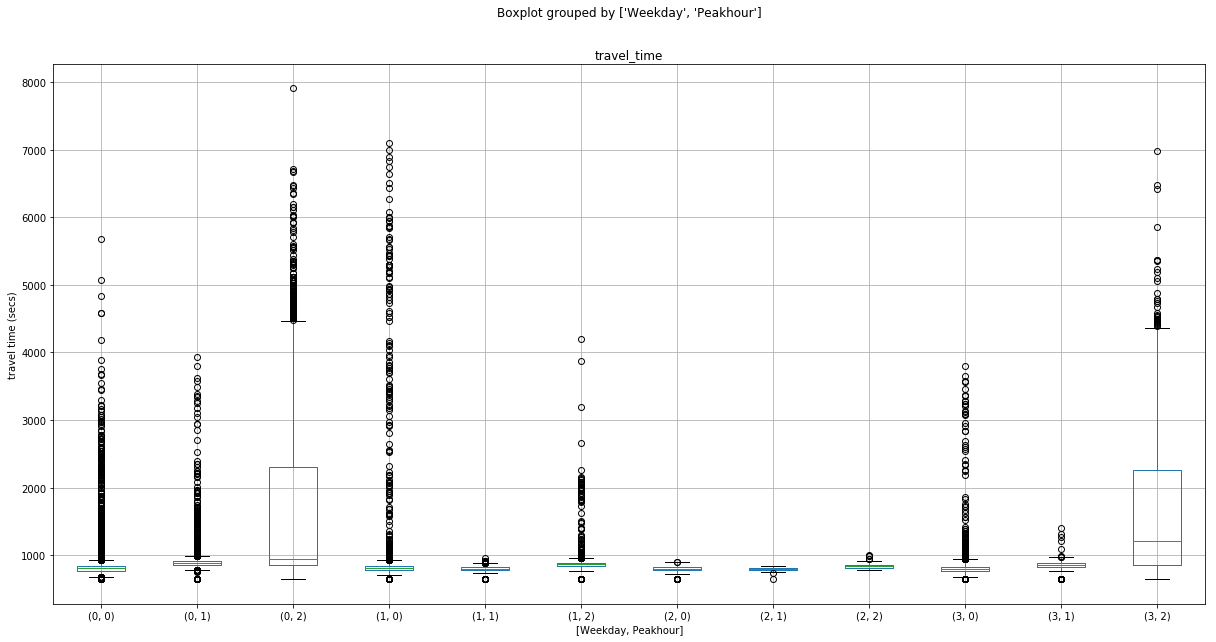

In [66]:
print("Variations within different week day and peakhour periods:")
df  =histdata[['Weekday','travel_time','Peakhour']]
df.boxplot(by=['Weekday','Peakhour'], figsize=(20,10))
plt.ylabel("travel time (secs)")

### 5) Modelling and Analysis
In this report, I look at three models for the predictions: knn regression, random forest regression and GradientBoost. First of all, let's devide the data into train and test samples.I have also introduced dummy coding for week days and peak hours.



#### 5.1 KNN Regressions 
Let's fit the KNN regreession with varying  nearest nighbours (k) to our historical data sets. I used the cross validation (prediction) metric to chose the optimal model. This optimal model is then used to predicte the unkown travel times.

Text(0,0.5,'MSEs from cross validation')

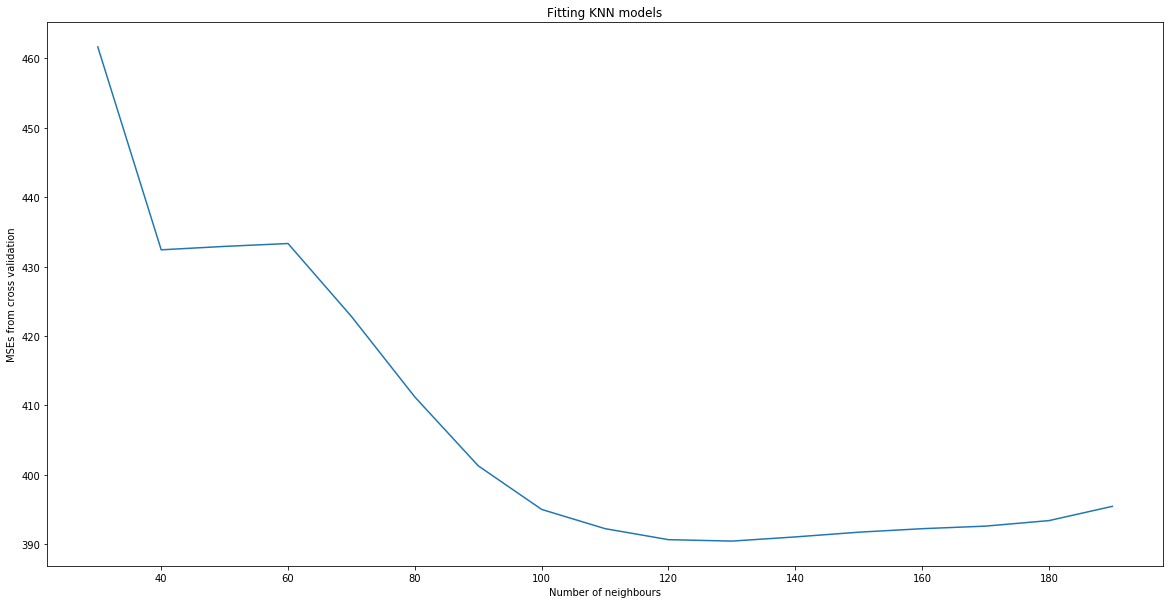

In [67]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_predict
mse = []
ed=[]
eu=[]
# The columns that we will be making predictions with.
mseknn = []
ed=[]
eu=[]
ll= list(range(30, 200, 10))
cols = ['wdays', 'wend', 'phol','shol', 'norm','peak1', 'peak2']
for kk in ll:
    knn = KNeighborsRegressor(n_neighbors=kk)
    #knn.fit(train[['Weekday', 'Peakhour']], train['travel_time'])
    # Make point predictions on the test set using the fit model.
    #predictions = knn.predict(test[['Weekday', 'Peakhour']])
    predictions=cross_val_predict(knn,histdata[cols],histdata['travel_time'])


    # Get the actual values for the test set.
    actual = histdata['travel_time']

    # Compute the mean squared error of our predictions.
    mseknn.append(np.sqrt((((predictions - actual) ** 2).sum()) / len(predictions)))

plt.figure(figsize=(20,10))
plt.plot(ll,mseknn)
plt.title('Fitting KNN models')
plt.xlabel('Number of neighbours')
plt.ylabel('MSEs from cross validation')

Predictions with CIs (KNN):


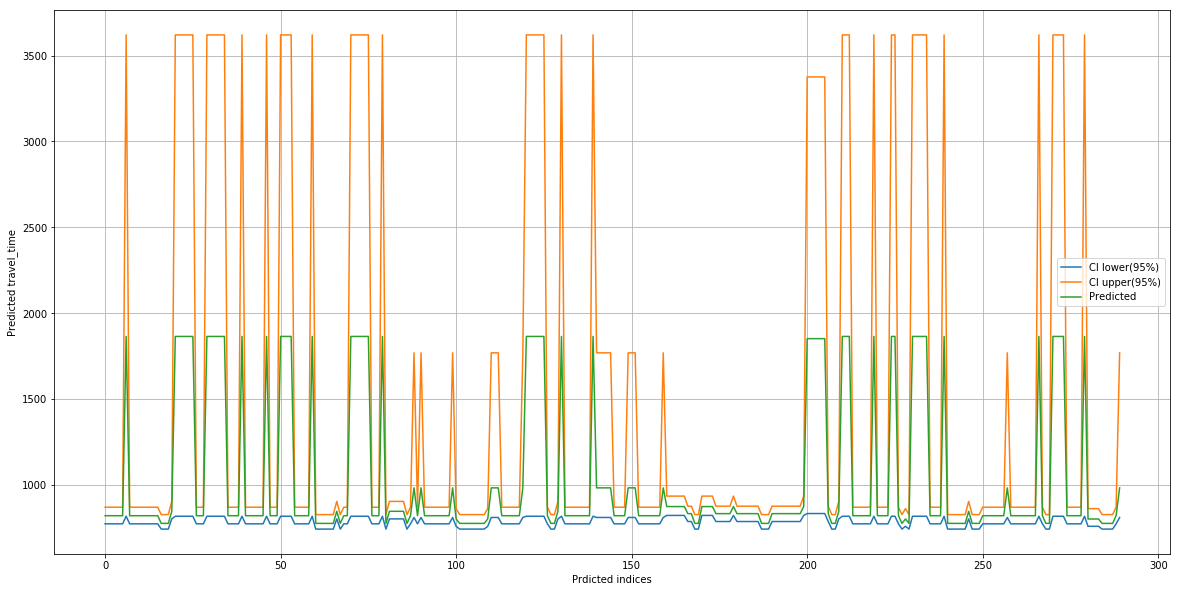

In [68]:
#estimate pred intervals
def pred_ints(ppreds, train, percentile=95):
    err_down = []
    err_up = []
    for ip in range(0,ppreds.shape[0]):
        ttime = train['travel_time'].values[ppreds[ip]]
        err_down.append(np.percentile(ttime, (100 - percentile) / 2. ))
        err_up.append(np.percentile(ttime, 100 - (100 - percentile) / 2.))
    return err_down, err_up

#predict and estimate CIs
knn = KNeighborsRegressor(n_neighbors=ll[np.argmin(mseknn)])
knn.fit(histdata[cols], histdata['travel_time'])
#Make point predictions on the test set using the fit model.
predictions = knn.predict(preddata[cols])
pp    = knn.kneighbors(preddata[cols])
CIlower,CIupper=pred_ints(pp[1], histdata,95)

print("Predictions with CIs (KNN):")
plt.figure(figsize=(20,10))
plt.plot(CIlower)
plt.plot(CIupper)
plt.plot(predictions)
plt.xlabel('Prdicted indices')
plt.ylabel('Predicted travel_time')
plt.legend(['CI lower(95%)', 'CI upper(95%)', 'Predicted'])
plt.grid()

#### 5.1 RandomForest Regressions 
Let's fit the RandomForest regression with varying  number of trees to our historical data set. I used the cross validation (prediction) metric to chose the optimal model. This optimal model is then used to predicte the unkown travel times.

Text(0,0.5,'MSEs from cross validation')

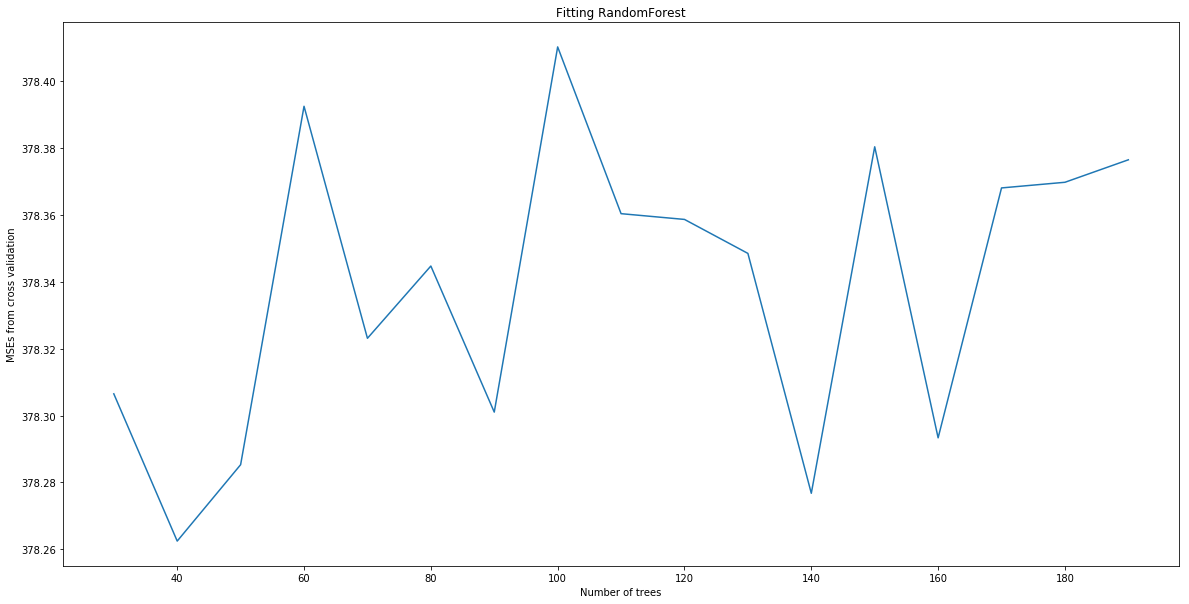

In [69]:
from sklearn.ensemble import RandomForestRegressor
mserf =[]
ll= list(range(30, 200, 10))
for kk in ll:
    clf = RandomForestRegressor(n_estimators = kk)
    #knn.fit(hd[['Weekday', 'Peakhour']], hd['travel_time'])
    # Make point predictions on the test set using the fit model.
    #predictions = knn.predict(test[['Weekday', 'Peakhour']])
    predictions=cross_val_predict(clf,histdata[cols],histdata['travel_time'])

#    e1,e2=pred_ints(predictions,95)
#    ed.append(e1)
#    eu.append(e2)
    # Get the actual values for the test set.
    actual = histdata['travel_time']

    # Compute the mean squared error of our predictions.
    mserf.append(np.sqrt((((predictions - actual) ** 2).sum()) / len(predictions)))
    
plt.figure(figsize=(20,10))
plt.plot(ll,mserf)
#plt.plot(ll,mseknn)
plt.title('Fitting RandomForest')
plt.xlabel('Number of trees')
plt.ylabel('MSEs from cross validation')
#plt.legend(['Randon Forest', 'KNN'])


In [70]:
from sklearn.ensemble import RandomForestRegressor
def pred_ints_rf(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            aa =X[x]
            aa=aa.reshape(1,aa.shape[0])
            preds.append(pred.predict(aa)[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up
#predict and estimate CIs
rf =RandomForestRegressor(n_estimators = ll[np.argmin(mserf)])
rf.fit(histdata[cols].values, histdata['travel_time'].values)

#Make point predictions on the test set using the fit model.
predictions = rf.predict(preddata[cols].values)

CIlower,CIupper=pred_ints_rf(rf,preddata[cols].values, 95)



Predictions with CIs (Random Forest):


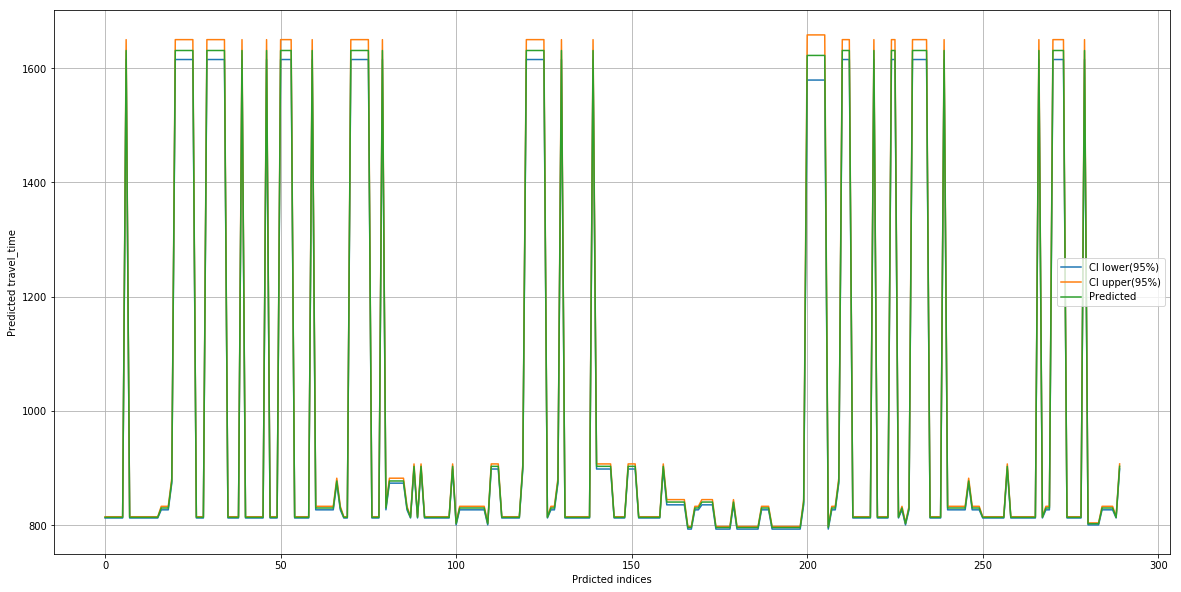

In [71]:
print("Predictions with CIs (Random Forest):")

plt.figure(figsize=(20,10))

plt.plot(CIlower)
plt.plot(CIupper)
plt.plot(predictions)
plt.xlabel('Prdicted indices')
plt.ylabel('Predicted travel_time')
plt.legend(['CI lower(95%)', 'CI upper(95%)', 'Predicted'])
plt.grid()

Text(0,0.5,'MSEs from cross validation')

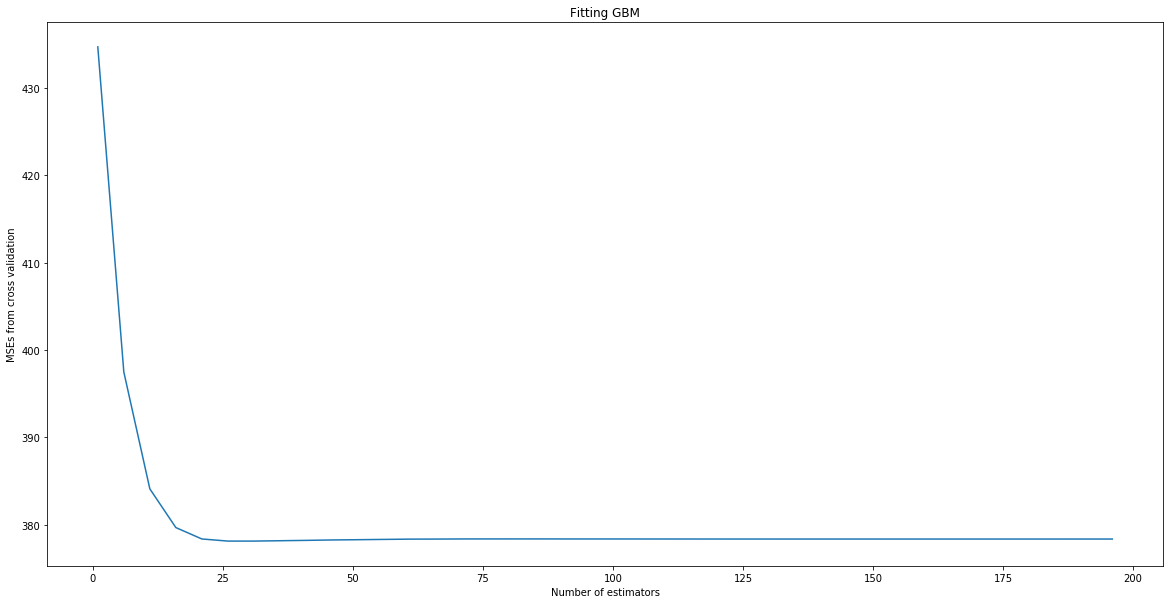

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt.fit(histdata[cols], histdata['travel_time'])
y_pred=gbrt.predict(preddata[cols]) 
msegbm =[]
ll1= list(range(1, 200, 5))
for kk in ll1:
    gbrt=GradientBoostingRegressor(n_estimators=kk)
    #knn.fit(hd[['Weekday', 'Peakhour']], hd['travel_time'])
    # Make point predictions on the test set using the fit model.
    #predictions = knn.predict(test[['Weekday', 'Peakhour']])
    predictions=cross_val_predict(gbrt,histdata[cols],histdata['travel_time'])

#    e1,e2=pred_ints(predictions,95)
#    ed.append(e1)
#    eu.append(e2)
    # Get the actual values for the test set.
    actual = histdata['travel_time']

    # Compute the mean squared error of our predictions.
    msegbm.append(np.sqrt((((predictions - actual) ** 2).sum()) / len(predictions)))
    
plt.figure(figsize=(20,10))
plt.plot(ll1,msegbm)
#plt.plot(ll,mseknn)
plt.title('Fitting GBM')
plt.xlabel('Number of estimators')
plt.ylabel('MSEs from cross validation')

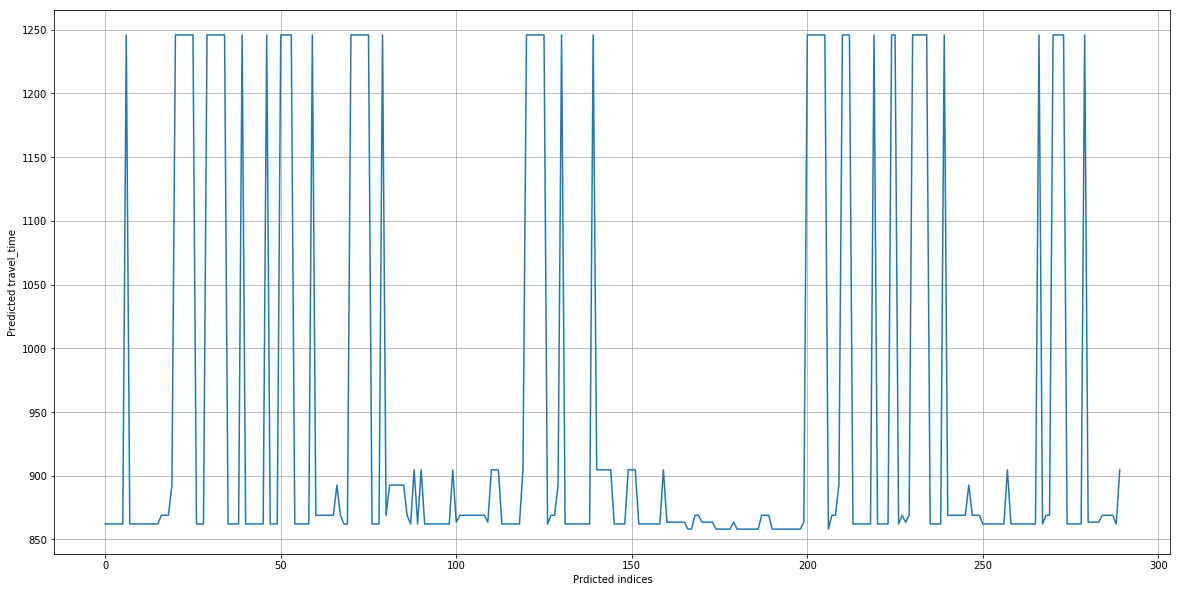

In [73]:
gbrt =GradientBoostingRegressor(n_estimators = ll1[np.argmin(mserf)])
gbrt.fit(histdata[cols].values, histdata['travel_time'].values)

#Make point predictions on the test set using the fit model.
predictions = gbrt.predict(preddata[cols].values)
predictions
plt.figure(figsize=(20,10))
plt.plot(predictions)
plt.xlabel('Prdicted indices')
plt.ylabel('Predicted travel_time')

plt.grid()

### 6) Conclusions
I have built two models: KNN, RandomForests and GBM to predict the travel time. All three gives very similar performances. From the box plot above, one can see that the variations in each group is very high. Hence, building a prediction models based on the given features are going to be a difficult task. If we have other information like weather, transport types, or extreme events like accidents & severe weaher conditons, we could have made use of those infomration to design a better prediction model(s).

Based on he MSEs of both models, The random forest seems to give lower cross-validation error, hence, may be a better choice. 
When we have extreme events like, accidents or storms, we can do further categorizations of the severity of these extreme events and based on the historical extreme events and assiciate travel-times, we may then adjust the average travel time to accomdate the additional delays.

In the context of the problem, combining modern machine learning models with tradiional models (together with other important data like weather, accidents and transport types woulde help us to build a better prediction models: **TBD**. 